In [39]:
import tarfile
import pandas as pd
import datetime as dt
import os
import glob
import subprocess
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import json

In [2]:
class Thermal:
    def get_tar(season, date, hour, minute):
        command = f'iget -rKTPf -N 0 /iplant/home/shared/terraref/ua-mac/level_1/{season}/EnvironmentLogger/{date}_clean.tar.gz'
        subprocess.call(command, shell = True)
        command = f'tar -xvf {date}_clean.tar.gz'
        subprocess.call(command, shell = True)

## Retrieve csv data and organize/clean up
    def retrieve_data(season, date, hour, minute):
        tar_data = Thermal.get_tar(season, date, hour, minute)
        data = pd.read_csv(f'./{date}_clean.csv')
        data['Time'] = pd.to_datetime(data['Time'])
        data['date'] = data.Time.dt.date
        data['time'] = data.Time.dt.time
        data_clean = data[['Time', 'time', 'date', 'Sun Direction', 'Temperature', 
                                      'Photosynthetically active radiation']]
        index_data = data_clean.set_index('time')
        return index_data

## Select Time Specified
    def split_time(season, date, hour, minute):
        index_data = Thermal.retrieve_data(season, date, hour, minute)
        specific_time = index_data[index_data.index == dt.time (hour, minute)]
        return specific_time

In [40]:
class JSON:
    def get_tar(season, date):
        command = f'iget -rKTPf -N 0 /iplant/home/shared/terraref/ua-mac/raw_tars/{season}/flirIrCamera/flirIrCamera-{date}.tar'
        subprocess.call(command, shell = True)
        command = f'tar -xvf flirIrCamera-{date}.tar'
        subprocess.call(command, shell = True)
    
    def pathlist(season, date):
        json_data = JSON.get_tar(season, date)
        pathlist = Path(f"./flirIrCamera/{date}/").glob('**/*.json')
        JSON_path_list = []
        for path in pathlist:
            path_str = str(path)
            JSON_path_list.append(path_str)
        return JSON_path_list
    
    def time_dict(season, date):
        file_path_list = JSON.pathlist(season, date)
        JSON_dict = dict()
        for file in file_path_list:
            path_metadata = glob.glob(f'{file}')
            metadata = str(path_metadata)[2:-2]
            with open(metadata) as f:
                meta = json.load(f)['lemnatec_measurement_metadata']
                time = (meta['gantry_system_variable_metadata']['time'])
                filename = os.path.basename(metadata)
            if JSON is not JSON_dict:
                JSON_dict[time, filename] = "Date, Time, and Image Name"
            else:
                print("JSON already in Dictionary")
        return sorted(JSON_dict)
    
    def time_df(season, date):
        JSON_time_d = JSON.time_dict(season, date)
        JSON_time_df = pd.DataFrame.from_dict(JSON_time_d)
        JSON_time_df.columns = ['Date and Time', 'Image Name']
        return JSON_time_df

In [13]:
EL_2020_03_03 = Thermal.retrieve_data('season_10_yr_2020', '2020-03-03', 10, 00)

In [14]:
EL_2020_03_03.reset_index(level=0, inplace=True)

In [41]:
JSON_time = JSON.time_df('season_10_yr_2020', '2020-03-03')

In [42]:
JSON_time['Date_Time']= pd.to_datetime(JSON_time['Date and Time'])

In [43]:
JSON_time['hour'] = JSON_time.Date_Time.dt.hour
JSON_time['minute'] = JSON_time.Date_Time.dt.minute
JSON_time['date'] = JSON_time.Date_Time.dt.date

In [44]:
JSON_time['time'] = pd.to_datetime(JSON_time['hour']*100 + JSON_time['minute'], format='%H%M').dt.time

In [17]:
EL_2020_03_03['minute'] = EL_2020_03_03.Time.dt.minute
Variance_minute = EL_2020_03_03.set_index('time').diff()
Variance_minute['Abs Temperature'] = Variance_minute['Temperature'].abs()

In [18]:
Variance_minute.reset_index(level=0, inplace=True)

In [45]:
Image_timestamp = JSON_time[['Date_Time']]

In [46]:
day_temp = Variance_hour['Abs Temperature']
day_time = EL_2020_03_03['Time']
first_time = Image_timestamp.iloc[0]
start = first_time['Date_Time']
last_time = Image_timestamp.iloc[-1]
end = last_time['Date_Time']

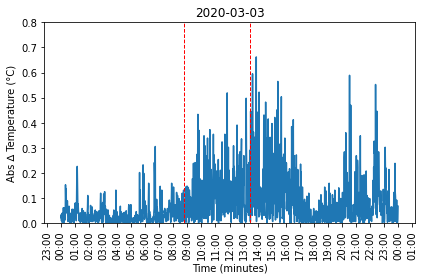

In [47]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)  
plt.plot(day_time, day_temp)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=90)
plt.xlabel("Time (minutes)")
plt.ylabel("Abs ∆ Temperature (°C)")
plt.title("2020-03-03")
plt.ylim(0,0.8)
xposition = [pd.to_datetime(f'{start}'), pd.to_datetime(f'{end}')]
for xc in xposition:
    ax.axvline(x=xc, color='r', linestyle='--', lw=1)
plt.tight_layout()